In [1]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
import statsmodels.api as sm
from project_utils import fourier_extrapolation

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)

beer = pd.read_csv('data/prod_target.txt')
beer['date'] = pd.to_datetime(beer['V1'])
beer.set_index('date', inplace=True)
beer = beer['V2']
beer.name = 'beer'
impute_dates = beer[beer.isna()].index

cars = pd.read_csv('data/prod_1.txt')
cars['date'] = pd.to_datetime(cars['V1'])
cars.set_index('date', inplace=True)
cars = cars['V2']
cars.name = 'cars'

steel = pd.read_csv('data/prod_2.txt')
steel['date'] = pd.to_datetime(steel['V1'])
steel.set_index('date', inplace=True)
steel = steel['V2']
steel.name = 'steel'

gas = pd.read_csv('data/eng_1.txt')
gas['date'] = pd.to_datetime(gas['V1'])
gas.set_index('date', inplace=True)
gas = gas['V2']
gas.name = 'gas'

elec = pd.read_csv('data/eng_2.txt')
elec['date'] = pd.to_datetime(elec['V1'])
elec.set_index('date', inplace=True)
elec = elec['V2']
elec.name = 'electricity'

temp = pd.read_csv('data/temp.txt')
date_df = temp[['X1943', 'X10']]
date_df.rename(columns={'X1943': 'year','X10':'month'}, inplace=True)
date_df['day'] = 1
date_df['date'] = pd.to_datetime(date_df)
temp.set_index(date_df['date'], inplace=True)
temp = temp['X20.4']
temp.name='temp'


df = pd.concat([beer, cars, steel, gas, elec, temp], axis=1)
per_1_start = beer[:impute_dates.min()].dropna().index.min()
per_1_start = cars.dropna().index.min()
per_1_end = beer[:impute_dates.min()].dropna().index.max()
per_2_start = beer[impute_dates.max():].dropna().index.min()
per_2_end = beer[impute_dates.max():].dropna().index.max()


per_1_start = beer[:impute_dates.min()].dropna().index.min()
per_1_end = beer[:impute_dates.min()].dropna().index.max()
per_2_start = beer[impute_dates.max():].dropna().index.min()
per_2_end = beer[impute_dates.max():].dropna().index.max()

per_1 = (per_1_start, per_1_end)
per_2 = (per_2_start, per_2_end)

names = list(df.columns)
plt_df = df[per_1[0]:per_2[1]]
plt_df.loc[impute_dates, 'beer'] = 140

C:\Users\Travis\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\Travis\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Travis\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, 

Text(0, 0.5, 'beer')

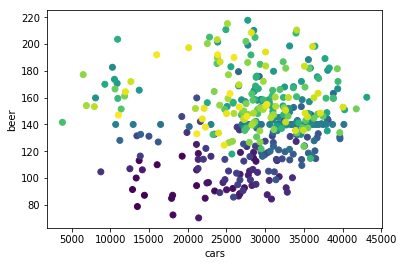

In [3]:
# run this cell to see the results for the next variable.
# ctrl-enter is a good hotkey for repeatedly running the same cell.
m = names.pop(0)

plt.scatter(x=plt_df[m], y=plt_df['beer'],
            c =list(range(len(plt_df))))
plt.xlabel(m)
plt.ylabel("beer")

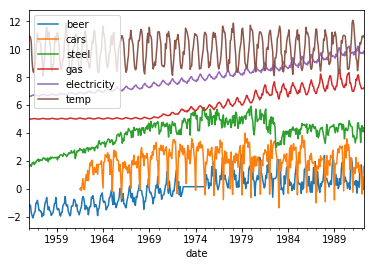

In [6]:
plt_df_norm =  2*np.arange(plt_df.shape[1]) + (plt_df -  plt_df.mean())/plt_df.std()
plt_df_norm.plot()

In [7]:
reg_1_df = plt_df['1962':per_1[1]]
test_df = plt_df.loc[impute_dates, ['cars', 'steel',
                                    'gas',
                                    'electricity', 'temp']]

X = reg_1_df[['cars', 'steel', 
              'gas',
              'electricity', 'temp']]
y = reg_1_df['beer']



model1 = auto_arima(y=y, exogenous=X, seasonal=True, m=12)

forward_pred = model1.predict(n_periods=len(impute_dates), exogenous=test_df)

C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

In [8]:
reg_2_df = plt_df[per_2[0]:'1985']
reg_2_df = reg_2_df.sort_index(ascending=False).reset_index()

test_df_rev = plt_df.loc[impute_dates, ['cars', 
                                        #'steel',
                                        #'gas', 'electricity', 
                                        'temp']].sort_index(ascending=False).reset_index(drop=True)

X = reg_2_df[['cars', 
             # 'steel', 
              #'gas', 'electricity',
              'temp']]
y = reg_2_df['beer']


model2 = auto_arima(y=y, exogenous=X, seasonal=True, m=12)
backward_pred = model2.predict(n_periods=len(impute_dates), exogenous=test_df_rev)

C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  retur

In [9]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  130
Model:             SARIMAX(1, 0, 0)x(1, 0, 2, 12)   Log Likelihood                -531.145
Date:                            Mon, 22 Apr 2019   AIC                           1078.290
Time:                                    17:12:36   BIC                           1101.230
Sample:                                         0   HQIC                          1087.612
                                            - 130                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8168      1.659      0.492      0.622      -2.435       4.068
x1             0.0013      0.000      3.074      0.002       0.000       0.002
x2             4.3549      1.053      4.135      0.000       2.291       6.419
ar.L1         -0.0146      0.107     -0.136      0.892      -0.225       0.195
ar.S.L12       0.9717      0.051     18.994      0.000       0.871       1.072
ma.S.L12      -0.7368      0.196     -3.768      0.000      -1.120      -0.354
ma.S.L24      -0.0295      0.144     -0.204      0.838      -0.312       0.253
sigma2       233.7481     40.373      5.790      0.000     154.619     312.877
===================================================================================
Ljung-Box (Q):                       33.79   Jarque-Bera (JB):                 3.30
Prob(Q):                              0.74   Prob(JB):                         0.19
Heteroskedasticity (H):               0.63   Skew:                             0.26
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
backward_pred = np.flip(backward_pred)

C:\Users\Travis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Travis\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Travis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel pack

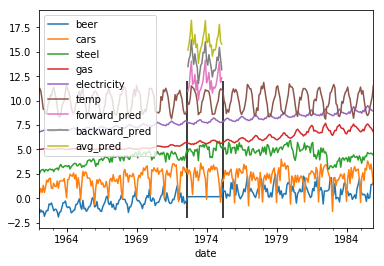

In [11]:

plt_df['forward_pred'] = float('nan')
plt_df.loc[impute_dates, 'forward_pred'] = forward_pred
plt_df.loc[impute_dates, 'backward_pred'] = backward_pred
plt_df.loc[impute_dates, 'avg_pred'] = (backward_pred + forward_pred)/2

plt_df_norm =  2*np.arange(plt_df.shape[1]) + (plt_df -  plt_df.mean())/plt_df.std()
plt_df_norm['1962':'1985'].plot()
plt.vlines(x=[per_1[1], per_2[0]], ymin = -2, ymax=12)

C:\Users\Travis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


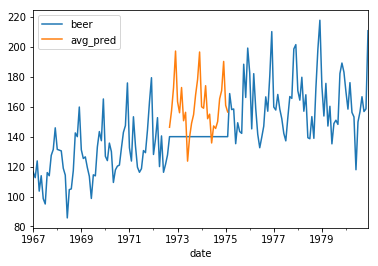

In [12]:
plt_df.loc['1967':'1980',['beer',  'avg_pred']].plot()
plt_df.loc[impute_dates, 'avg_pred'].to_csv('Scenario Results 3.csv')

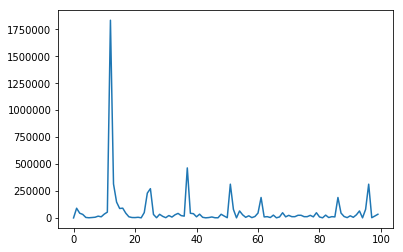

In [13]:
def thresh_coeffs(lower, upper, coeffs):
    powers = np.abs(coeffs)**2
    thresh_coeff = coeffs.copy()
    thresh_coeff[powers>powers[powers.argsort()[  upper]]] = 0
    thresh_coeff[powers<powers[powers.argsort()[ lower]]] = 0
    return thresh_coeff



for_df = df.loc['1980':, :]#['beer', 'temp']]
fourier_coeff = np.fft.fft(for_df.beer-for_df.beer.mean())
powers = np.abs(fourier_coeff)**2
plt.plot((np.abs(fourier_coeff)**2)[:100])


C:\Users\Travis\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  """


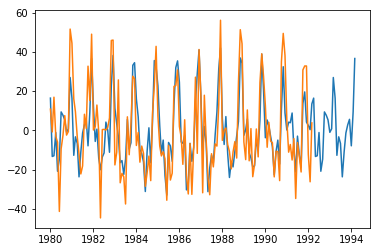

In [14]:
filtered_coef = thresh_coeffs(-10,-1,fourier_coeff)

filtered = np.real(np.fft.ifft(filtered_coef))
w_extrap = np.concatenate([filtered,fourier_extrapolation(filtered_coef, 24)])
forecast_ind  =pd.DatetimeIndex(start=for_df.index.max(),periods=25, freq='MS')[1:]
w_extrap = pd.Series(w_extrap, index = for_df.index.append(forecast_ind))
plt.plot(w_extrap)
centered_beer = for_df.beer-for_df.beer.mean()
plt.plot(for_df.beer-for_df.beer.mean())

In [15]:
exog = pd.DataFrame(filtered,columns=['seasonal'], index=for_df.index)
model  =VARMAX(for_df, exog=exog, order=(1,1))

model_fit = model.fit()

C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either i

In [16]:
exog_test = pd.DataFrame(w_extrap[forecast_ind.min():], columns=['seasonal'])
model_fit.summary()

C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\Travis\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Travis\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Travis\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Dep. Variable:,"['beer', 'cars', 'steel', 'gas', 'electricity', 'temp']",No. Observations:,147
Model:,"VARMAX(1,1)",Log Likelihood,-5605.734
,+ intercept,AIC,11421.468
Date:,"Mon, 22 Apr 2019",BIC,11735.464
Time:,17:14:19,HQIC,11549.048
Sample:,01-01-1980,,
,- 03-01-1992,,
Covariance Type:,opg,,
Ljung-Box (Q):,"190.84, 304.86, 54.55, 163.81, 111.94, 39.96",Jarque-Bera (JB):,"4.14, 2.57, 24.44, 1.23, 0.48, 1.14"
Prob(Q):,"0.00, 0.00, 0.06, 0.00, 0.00, 0.47",Prob(JB):,"0.13, 0.28, 0.00, 0.54, 0.79, 0.56"
Heteroskedasticity (H):,"0.76, 1.11, 0.36, 1.27, 0.94, 0.89",Skew:,"0.41, 0.06, 0.08, 0.11, 0.04, -0.13"


C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


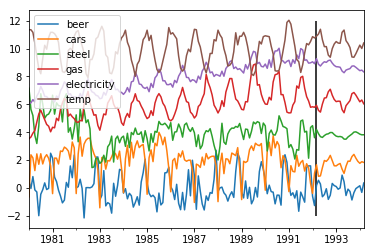

In [17]:
forecast = model_fit.forecast( exog= exog_test,  steps=24)
forecast = pd.DataFrame(forecast, columns=for_df.columns, index=forecast_ind)
VAR_df = pd.concat([for_df, forecast])
#plt.hlines()

df_norm =  2*np.arange(VAR_df.shape[1]) + (VAR_df -  VAR_df.mean())/VAR_df.std()
df_norm.plot()
plt.vlines(for_df.index.max(), ymin=-2, ymax=12)

In [20]:
fit = auto_arima(for_df.beer, seasonal=True, m=12)

C:\Users\Travis\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:873: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Travis\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:

In [ ]:
forecast = fit.predict(n_periods=24, alpha=0.05, return_conf_int=True)
ci_s = pd.DataFrame(forecast[1], columns=['lower', 'upper'], index=forecast_ind)

forecast = pd.DataFrame(forecast[0], columns=['beer_forecast'], index=forecast_ind)

sarima_df = pd.concat([for_df.beer, forecast, ci_s], axis=1)

#plt.hlines()

sarima_df.plot()

In [24]:
forecast.to_csv('Dunn_Scenario4_raw.csv')